In [3]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [41]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train, X_valid = X_train[5000:] / 255.0, X_train[:5000] / 255.0
y_train, y_valid = y_train[5000:], y_train[:5000]
X_train, X_valid, X_test = np.expand_dims(X_train, -1), np.expand_dims(X_valid, -1), np.expand_dims(X_test, -1)
print(f"""
Training set: {(X_train.shape, y_train.shape)},
Validation set: {(X_valid.shape, y_valid.shape)} and
Test set: {(X_test.shape, y_test.shape)}
""")


Training set: ((55000, 28, 28, 1), (55000,)),
Validation set: ((5000, 28, 28, 1), (5000,)) and
Test set: ((10000, 28, 28, 1), (10000,))



In [43]:
import pandas as pd
df = pd.read_csv("../input/aug-dataset-without-blurring/aug_dataset_affines_withoug_blurring.csv", index_col = 0)
X_train = np.array(df.iloc[:, :784]).reshape((75625, 28, 28, 1))
y_train = np.array(df.iloc[:, 784]).reshape((75625))
X_train.shape, y_train.shape

((75625, 28, 28, 1), (75625,))

# Hyperparameter tuning

In [ ]:
import keras_tuner as kt

In [ ]:
def build_model(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28, 28]))
    for i in range(hp.Int("num_layers", 1, 5)):
        units_ = hp.Int(f"units_{i}", min_value = 10, max_value = 500, step = 25)
        activation_ = hp.Choice(f"activation_{i}", ["relu", "leaky_relu", "elu", "selu"]) 
        if activation_ == "selu":
            kernel_initializer_ = "lecun_normal"
        else:
            kernel_initializer_ = "he_normal"
        model.add(
            keras.layers.Dense(
                units = units_,
                activation = activation_,
                kernel_initializer = kernel_initializer_
            )
        )
        model.add(
            keras.layers.Dropout(rate = 0.25)
        )
    model.add(keras.layers.Dense(10, activation = "softmax", kernel_initializer = "glorot_normal"))
    learning_rate_ = hp.Choice("learning_rate", [0.0001, 0.001, 0.01])
    
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = learning_rate_), loss = keras.losses.sparse_categorical_crossentropy, metrics = ["accuracy"])
    return model

In [ ]:
tuner = kt.Hyperband(build_model, objective = "val_accuracy", max_epochs = 50, factor = 2, project_name = "mnist_project_v01")

In [ ]:
tuner.search(X_valid, y_valid, epochs = 10, validation_split = 0.25, callbacks = [keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5)])
best_hps = tuner.get_best_hyperparameters()[0]
print(f"""
The hyperparameter search is complete. Here are the results:
Num of layers: {best_hps.get("num_layers")},
Num of units: 
layer1: {best_hps.get("units_0")},
layer2: {best_hps.get("units_1")},
layer3: {best_hps.get("units_2")},
layer4: {best_hps.get("units_3")},
layer5: {best_hps.get("units_4")},
Activation of layers: 
layer1: {best_hps.get("activation_0")},
layer2: {best_hps.get("activation_1")},
layer3: {best_hps.get("activation_2")},
layer4: {best_hps.get("activation_3")},
layer5: {best_hps.get("activation_4")} and
Learning rate: {best_hps.get("learning_rate")}
""")

In [ ]:
model = tuner.get_best_models(num_models = 1)
model[0].summary()

In [ ]:
history = model[0].fit(
    X_train, y_train, 
    epochs = 500, validation_data = (X_valid, y_valid),
    callbacks = [keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True)]
)

In [ ]:
model[0].evaluate(X_test, y_test)

# Convolutional Net

In [110]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, 4, activation = "relu", kernel_initializer = "he_normal", padding = "same", input_shape = [28, 28, 1]),
    keras.layers.Conv2D(64, 4, activation = "relu", kernel_initializer = "he_normal", padding = "same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation = "relu", kernel_initializer = "he_normal", padding = "same"),
    keras.layers.AveragePooling2D(2),
    keras.layers.Conv2D(128, 3, activation = "relu", kernel_initializer = "he_normal", padding = "same"),
    keras.layers.AveragePooling2D(2),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Dense(10, activation = "softmax", kernel_initializer = "glorot_normal")
])
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 28, 28, 32)        544       
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 28, 28, 64)        32832     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
average_pooling2d_48 (Averag (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 7, 7, 128)         147584    
_________________________________________________________________
average_pooling2d_49 (Averag (None, 3, 3, 128)       

In [111]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [112]:
history = model.fit(
    X_train, y_train, 
    epochs = 500, validation_data = (X_valid, y_valid),
    callbacks = [keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)]
)

Epoch 1/500
2364/2364 [==============================] - 14s 6ms/step - loss: 0.2471 - accuracy: 0.9204 - val_loss: 0.0458 - val_accuracy: 0.9848
Epoch 2/500
2364/2364 [==============================] - 13s 6ms/step - loss: 0.0663 - accuracy: 0.9802 - val_loss: 0.0281 - val_accuracy: 0.9922
Epoch 3/500
2364/2364 [==============================] - 14s 6ms/step - loss: 0.0456 - accuracy: 0.9858 - val_loss: 0.0293 - val_accuracy: 0.9906
Epoch 4/500
2364/2364 [==============================] - 14s 6ms/step - loss: 0.0368 - accuracy: 0.9889 - val_loss: 0.0178 - val_accuracy: 0.9940
Epoch 5/500
2364/2364 [==============================] - 14s 6ms/step - loss: 0.0297 - accuracy: 0.9907 - val_loss: 0.0133 - val_accuracy: 0.9952
Epoch 6/500
2364/2364 [==============================] - 13s 6ms/step - loss: 0.0243 - accuracy: 0.9920 - val_loss: 0.0102 - val_accuracy: 0.9968
Epoch 7/500
2364/2364 [==============================] - 15s 6ms/step - loss: 0.0207 - accuracy: 0.9934 - val_loss: 0.0100 -

In [ ]:
model.evaluate(X_test, y_test)

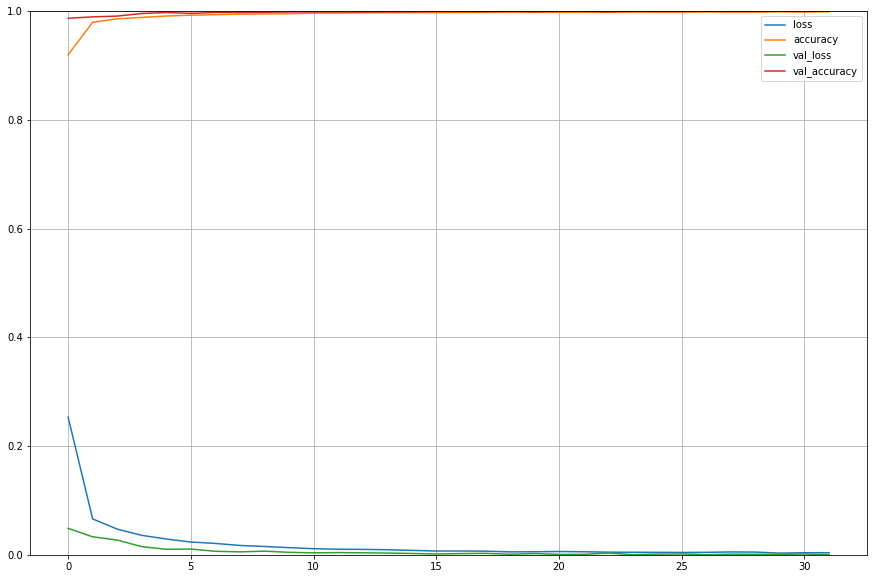

In [93]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize = (15, 10))
plt.grid(True)
plt.ylim(0, 1)
plt.show()

In [94]:
model.save("model_9958.h5")

In [4]:
model_x = keras.models.load_model("./model_9958.h5")

OSError: SavedModel file does not exist at: ./model_9958.h5/{saved_model.pbtxt|saved_model.pb}